Dataset shape: (3662, 2)
        id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0

Missing values:
id_code      0
diagnosis    0
dtype: int64

Diagnosis distribution:
diagnosis
0    1805
1     370
2     999
3     193
4     295
Name: count, dtype: int64


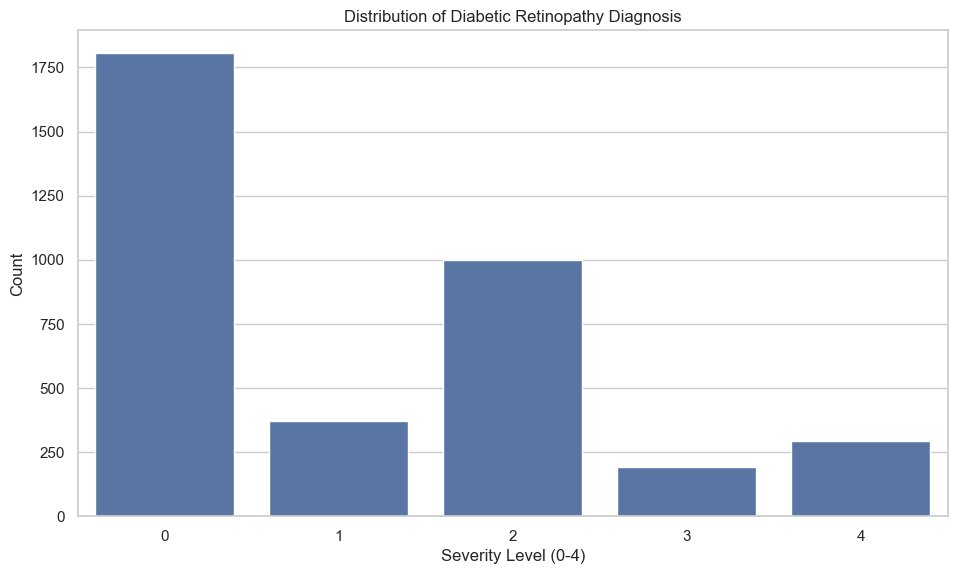


Percentage distribution:
Class 0: 49.29%
Class 1: 10.10%
Class 2: 27.28%
Class 3: 5.27%
Class 4: 8.06%


100%|██████████| 100/100 [00:00<00:00, 1343.53it/s]


Image dimensions summary:
Width - Min: 640, Max: 4288, Mean: 2177.7
Height - Min: 480, Max: 2848, Mean: 1633.3


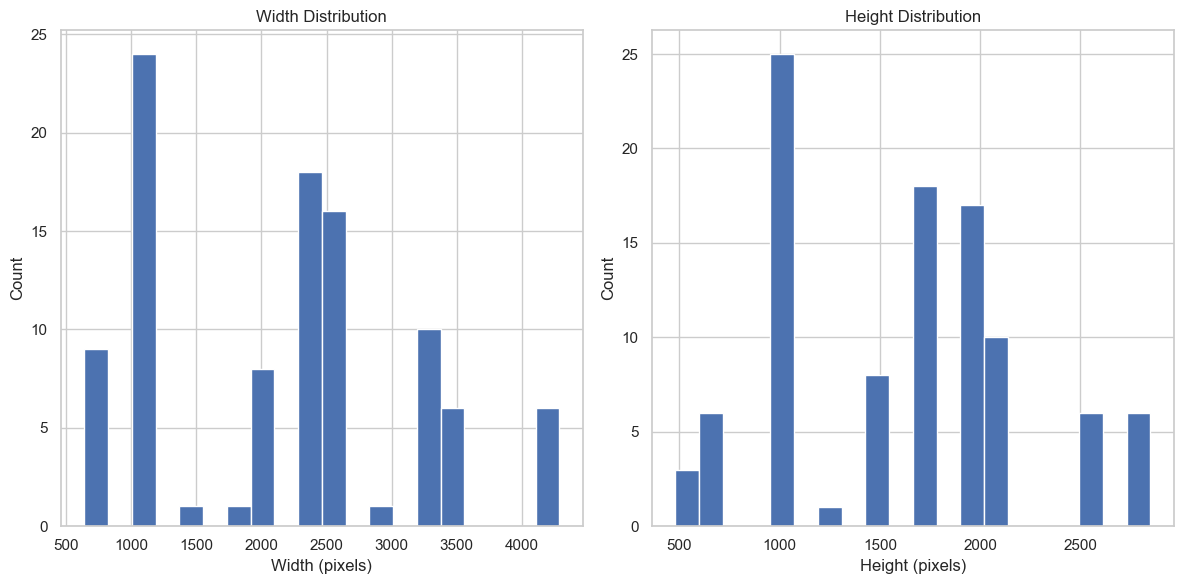

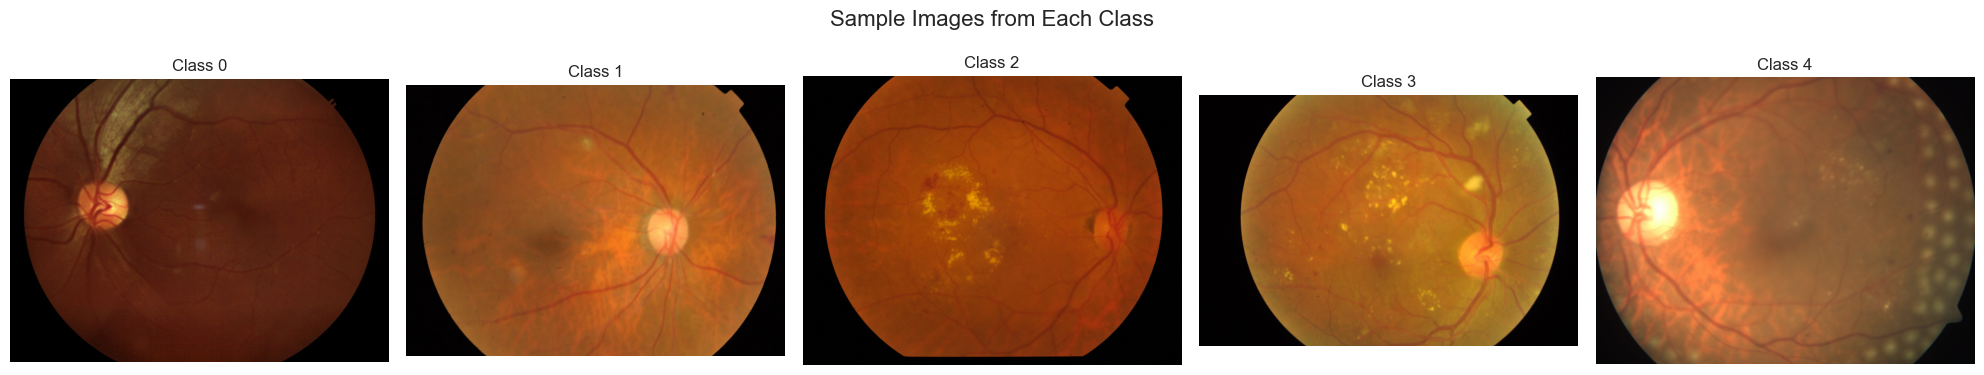

Class 4: 100%|██████████| 100/100 [00:06<00:00, 15.63it/s]


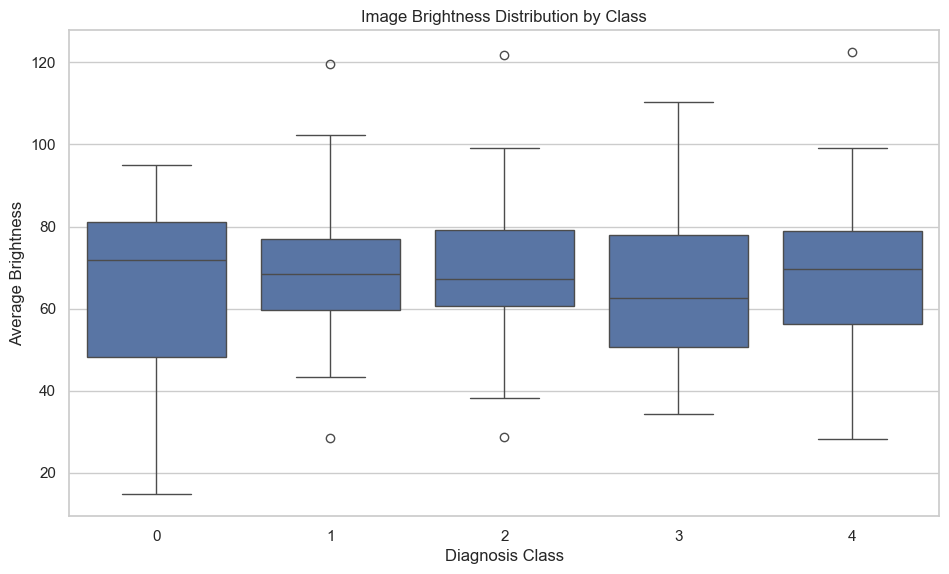

Extracting features: 100%|██████████| 200/200 [00:11<00:00, 17.21it/s]


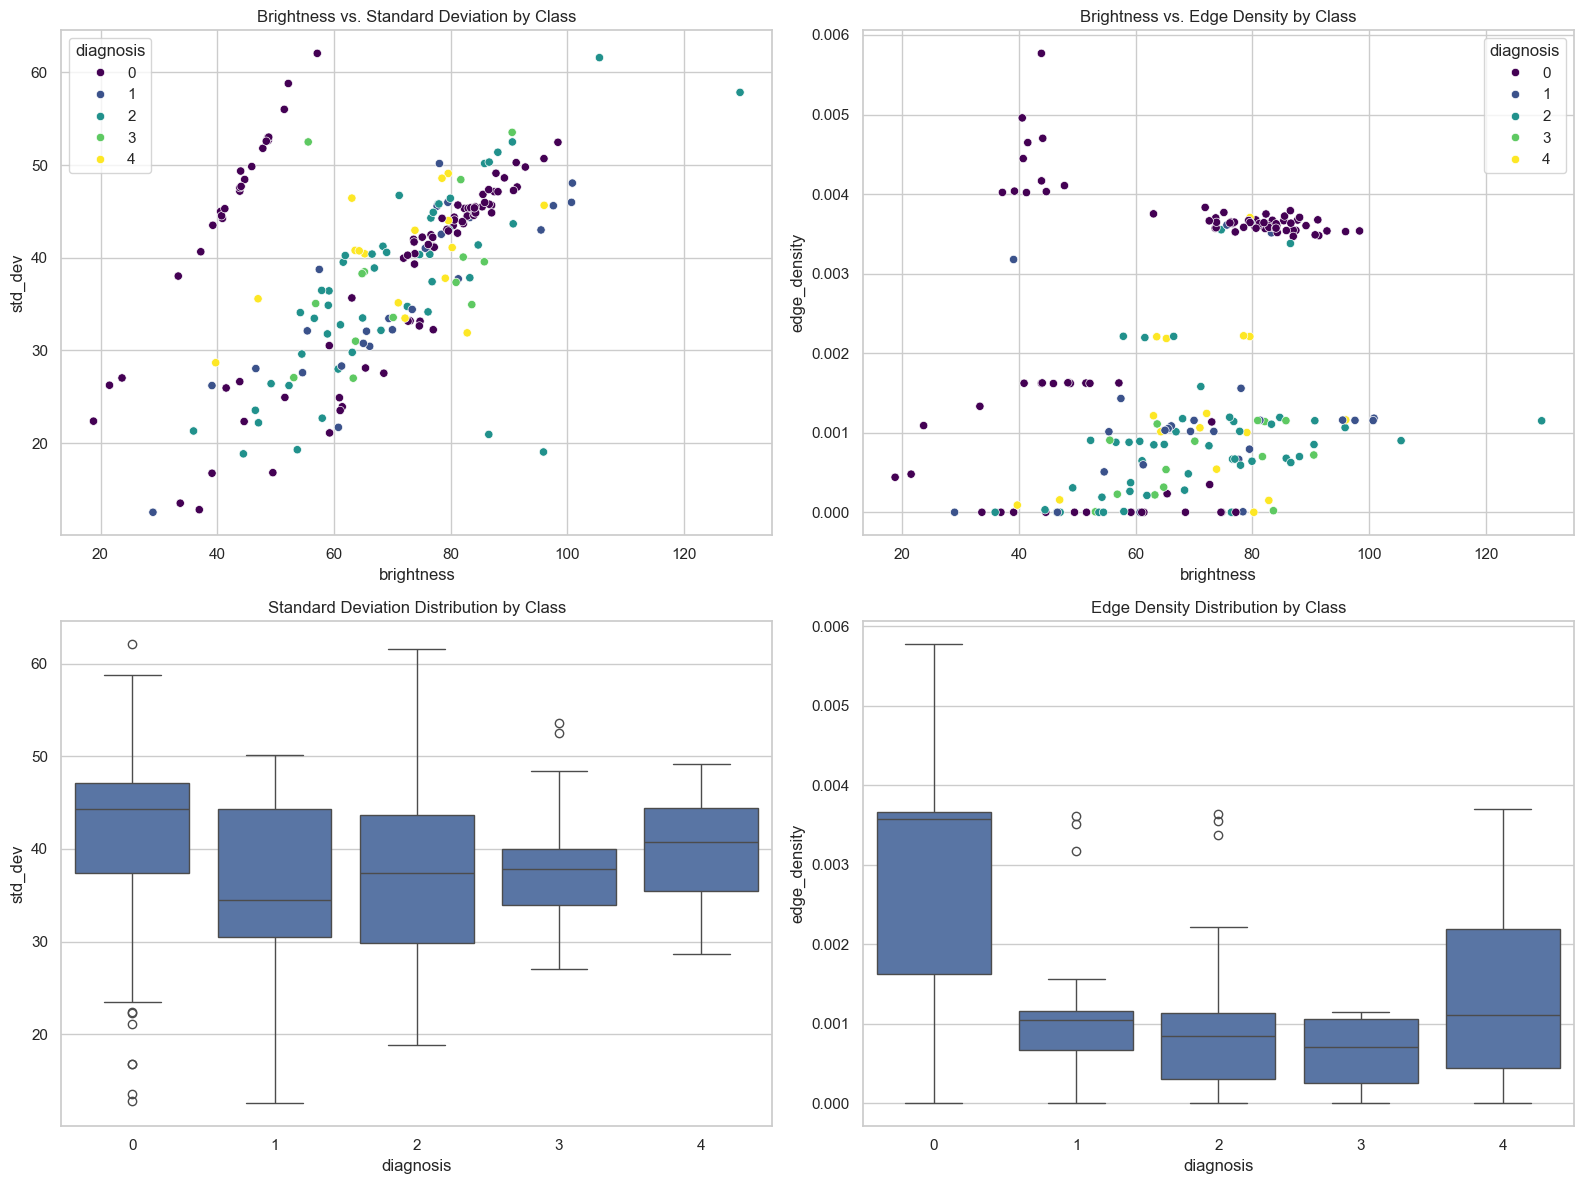


Train-test split:
Training set: 2929 images
Testing set: 733 images

Class distribution comparison:
           Training Set (%)  Testing Set (%)
diagnosis                                   
0                 49.300102        49.249659
1                 10.105838        10.095498
2                 27.278935        27.285130
3                  5.257767         5.320600
4                  8.057357         8.049113


<Figure size 1200x600 with 0 Axes>

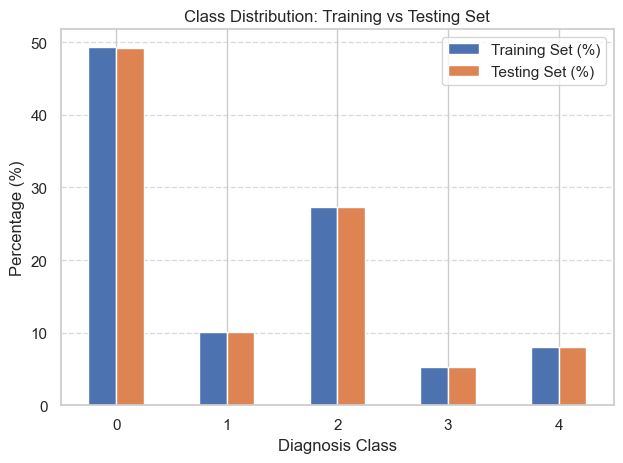


Dataset Summary:
Total images: 3662
Number of classes: 5
Class 0: 1805 images (49.3%)
Class 1: 370 images (10.1%)
Class 2: 999 images (27.3%)
Class 3: 193 images (5.3%)
Class 4: 295 images (8.1%)


In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Set style for plots
plt.style.use('fivethirtyeight')
sns.set(style='whitegrid')

# Paths - update these to match your directory structure
BASE_DIR = r'C:\Users\mail2\OneDrive\Documents\WorkSpace\University\Year 3\CSC490\Retinal-Disease-Detection\aptos2019-blindness-detection'
TRAIN_CSV = os.path.join(BASE_DIR, 'train.csv')
TRAIN_IMAGES_DIR = os.path.join(BASE_DIR, 'train_images')

# Load the CSV data
df = pd.read_csv(TRAIN_CSV)
print(f"Dataset shape: {df.shape}")
print(df.head())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Distribution of diagnosis labels
print("\nDiagnosis distribution:")
print(df['diagnosis'].value_counts().sort_index())

plt.figure(figsize=(10, 6))
sns.countplot(x='diagnosis', data=df)
plt.title('Distribution of Diabetic Retinopathy Diagnosis')
plt.xlabel('Severity Level (0-4)')
plt.ylabel('Count')
plt.show()

# Calculate percentage of each class
diagnosis_counts = df['diagnosis'].value_counts(normalize=True) * 100
print("\nPercentage distribution:")
for i, percentage in diagnosis_counts.sort_index().items():
    print(f"Class {i}: {percentage:.2f}%")

# Check image dimensions
def get_image_dimensions(image_id):
    img_path = os.path.join(TRAIN_IMAGES_DIR, f"{image_id}.png")
    img = Image.open(img_path)
    return img.size

# Get dimensions for a sample of images (limit to 100 to avoid slow processing)
sample_ids = np.random.choice(df['id_code'].values, min(100, len(df)), replace=False)
dimensions = [get_image_dimensions(img_id) for img_id in tqdm(sample_ids)]
widths, heights = zip(*dimensions)

print("\nImage dimensions summary:")
print(f"Width - Min: {min(widths)}, Max: {max(widths)}, Mean: {np.mean(widths):.1f}")
print(f"Height - Min: {min(heights)}, Max: {max(heights)}, Mean: {np.mean(heights):.1f}")

# Plot image dimensions distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(widths, bins=20)
plt.title('Width Distribution')
plt.xlabel('Width (pixels)')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(heights, bins=20)
plt.title('Height Distribution')
plt.xlabel('Height (pixels)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Display sample images from each class
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    sample = df[df['diagnosis'] == i].sample(1).iloc[0]
    img_path = os.path.join(TRAIN_IMAGES_DIR, f"{sample['id_code']}.png")
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img)
    axes[i].set_title(f"Class {i}")
    axes[i].axis('off')
plt.suptitle('Sample Images from Each Class', fontsize=16)
plt.tight_layout()
plt.show()

# Image analysis - average brightness per class
def get_brightness(image_id):
    img_path = os.path.join(TRAIN_IMAGES_DIR, f"{image_id}.png")
    img = cv2.imread(img_path, 0)  # Read as grayscale
    return img.mean()

# Sample some images from each class for brightness analysis
sample_size = min(100, len(df) // 5)  # Up to 100 images per class
brightness_data = []

for diagnosis in range(5):
    class_samples = df[df['diagnosis'] == diagnosis].sample(min(sample_size, len(df[df['diagnosis'] == diagnosis])))
    for _, row in tqdm(class_samples.iterrows(), total=len(class_samples), desc=f"Class {diagnosis}"):
        brightness_data.append({
            'id_code': row['id_code'],
            'diagnosis': row['diagnosis'],
            'brightness': get_brightness(row['id_code'])
        })

brightness_df = pd.DataFrame(brightness_data)

plt.figure(figsize=(10, 6))
sns.boxplot(x='diagnosis', y='brightness', data=brightness_df)
plt.title('Image Brightness Distribution by Class')
plt.xlabel('Diagnosis Class')
plt.ylabel('Average Brightness')
plt.show()

# Create a function to extract simple image features
def extract_image_features(image_id):
    img_path = os.path.join(TRAIN_IMAGES_DIR, f"{image_id}.png")
    img = cv2.imread(img_path)
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Features
    brightness = gray.mean()
    std = gray.std()
    
    # Edge detection using Canny
    edges = cv2.Canny(gray, 100, 200)
    edge_density = np.sum(edges > 0) / (edges.shape[0] * edges.shape[1])
    
    return brightness, std, edge_density

# Sample for feature extraction
sample_ids = df.sample(min(200, len(df)))['id_code'].values
features = []

for img_id in tqdm(sample_ids, desc="Extracting features"):
    brightness, std, edge_density = extract_image_features(img_id)
    diagnosis = df[df['id_code'] == img_id]['diagnosis'].values[0]
    features.append({
        'id_code': img_id,
        'diagnosis': diagnosis,
        'brightness': brightness,
        'std_dev': std,
        'edge_density': edge_density
    })

features_df = pd.DataFrame(features)

# Plot feature relationships
plt.figure(figsize=(16, 12))

plt.subplot(2, 2, 1)
sns.scatterplot(x='brightness', y='std_dev', hue='diagnosis', data=features_df, palette='viridis')
plt.title('Brightness vs. Standard Deviation by Class')

plt.subplot(2, 2, 2)
sns.scatterplot(x='brightness', y='edge_density', hue='diagnosis', data=features_df, palette='viridis')
plt.title('Brightness vs. Edge Density by Class')

plt.subplot(2, 2, 3)
sns.boxplot(x='diagnosis', y='std_dev', data=features_df)
plt.title('Standard Deviation Distribution by Class')

plt.subplot(2, 2, 4)
sns.boxplot(x='diagnosis', y='edge_density', data=features_df)
plt.title('Edge Density Distribution by Class')

plt.tight_layout()
plt.show()

# Train-test split analysis
X_train, X_test, y_train, y_test = train_test_split(
    df['id_code'], df['diagnosis'], test_size=0.2, stratify=df['diagnosis'], random_state=42
)

print("\nTrain-test split:")
print(f"Training set: {len(X_train)} images")
print(f"Testing set: {len(X_test)} images")

# Compare class distributions
train_dist = pd.Series(y_train).value_counts(normalize=True).sort_index() * 100
test_dist = pd.Series(y_test).value_counts(normalize=True).sort_index() * 100

dist_comparison = pd.DataFrame({
    'Training Set (%)': train_dist,
    'Testing Set (%)': test_dist
})

print("\nClass distribution comparison:")
print(dist_comparison)

plt.figure(figsize=(12, 6))
dist_comparison.plot(kind='bar')
plt.title('Class Distribution: Training vs Testing Set')
plt.xlabel('Diagnosis Class')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# Summary statistics
print("\nDataset Summary:")
print(f"Total images: {len(df)}")
print(f"Number of classes: {df['diagnosis'].nunique()}")
for i in range(5):
    print(f"Class {i}: {len(df[df['diagnosis'] == i])} images ({len(df[df['diagnosis'] == i])/len(df)*100:.1f}%)")